# Predicciones de contaminacion

Las Magnitudes que nos interesa predecir son las siguientes:
PM25
PM10
O3

Acorde a la matriz de correlacion las magnitudes PM25 y PM10 estan fuertemente correlacionadas por 
lo que una regrecion que considere ambas variables puede aumentar su precicion. Debido a que O3 tiene una correlacion baja con PM25 y PM10 se entrenara un modelo por su cuenta


In [2]:
import pandas as pd

df = pd.read_csv("../TimeStepData.csv")

In [ ]:
# unhealthy sensors have been removed already and gaps have been filled
df.head()


,Datetime,CO_ANL1,CO_ANL10,CO_ANL11,CO_ANL12,CO_ANL13,CO_ANL2,CO_ANL3,CO_ANL4,CO_ANL5,...,VIENTOVEL_ANL11,VIENTOVEL_ANL12,VIENTOVEL_ANL13,VIENTOVEL_ANL2,VIENTOVEL_ANL3,VIENTOVEL_ANL4,VIENTOVEL_ANL5,VIENTOVEL_ANL6,VIENTOVEL_ANL8,VIENTOVEL_ANL9
0,2022-01-01 00:00:00,0.94,1.39,1.77,1.57,1.330,1.24,1.36,1.00,0.65,...,7.100000,7.500000,5.300000,9.633333,7.900000,8.966667,6.766667,11.033333,6.466667,7.233333
1,2022-01-01 01:00:00,1.05,1.50,1.36,1.57,1.600,1.35,1.53,1.13,0.70,...,7.266667,5.333333,2.900000,5.966667,6.300000,11.033333,5.533333,8.366667,3.466667,4.900000
2,2022-01-01 02:00:00,1.15,2.03,1.28,1.66,1.400,1.77,1.60,1.23,0.86,...,3.900000,5.166667,3.066667,4.533333,4.333333,7.900000,4.033333,5.333333,3.033333,2.366667
3,2022-01-01 03:00:00,1.57,2.18,1.48,1.76,2.460,2.38,2.01,1.37,1.47,...,6.200000,4.833333,3.233333,5.600000,4.200000,5.933333,3.900000,4.466667,3.700000,3.633333
4,2022-01-01 04:00:00,2.05,2.07,1.61,2.38,2.604,2.88,3.09,1.50,1.99,...,5.666667,4.933333,3.066667,6.566667,4.600000,7.900000,4.033333,3.566667,2.466667,3.333333


In [9]:
def transform(df, desired_columns):
    final_dataframe = df
    for column in df.columns:
        if column.split("_")[0] not in desired_columns:
            final_dataframe = final_dataframe.drop(columns=column)

    return final_dataframe

# first we must have a dataset for our model of PM25 and PM10 predictions and our dataset for our
# O3 predictions

desired_magnitudes_pm = ["PM25", "PM10"]

pm_regressor_dataset = transform(df, desired_magnitudes_pm)
o3_regressor_dataset = transform(df, ["O3"])

In [14]:
# split data for training and testing

TRAIN_PERCENTAGE = 0.995

def train_test_split(df, train_percentage: float):
    train_df = df[:int(train_percentage*len(df))]
    test_df= df[int(train_percentage*len(df)):]
    return train_df, test_df


train_pm_df, test_pm_df = train_test_split(pm_regressor_dataset, TRAIN_PERCENTAGE)
train_o3_df, test_o3_df = train_test_split(o3_regressor_dataset, TRAIN_PERCENTAGE)




In [25]:

import matplotlib.pyplot as plt

def graph_metric(data_frame: pd.DataFrame, metric_name: str):
    # number of sensors after drop
    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in data_frame.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(data_frame.index, data_frame[col])
            axs[i].set_title(col)
            i += 1

def graph_metrics(forecast_df: pd.DataFrame, true_df: pd.DataFrame, metric_name: str):
    # number of sensors after drop

    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in forecast_df.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(forecast_df.index, forecast_df[col], label="forecast")
            axs[i].plot(true_df.index, true_df[col], label="truth")
            axs[i].set_title(col)
            i += 1



In [15]:
%matplotlib inline

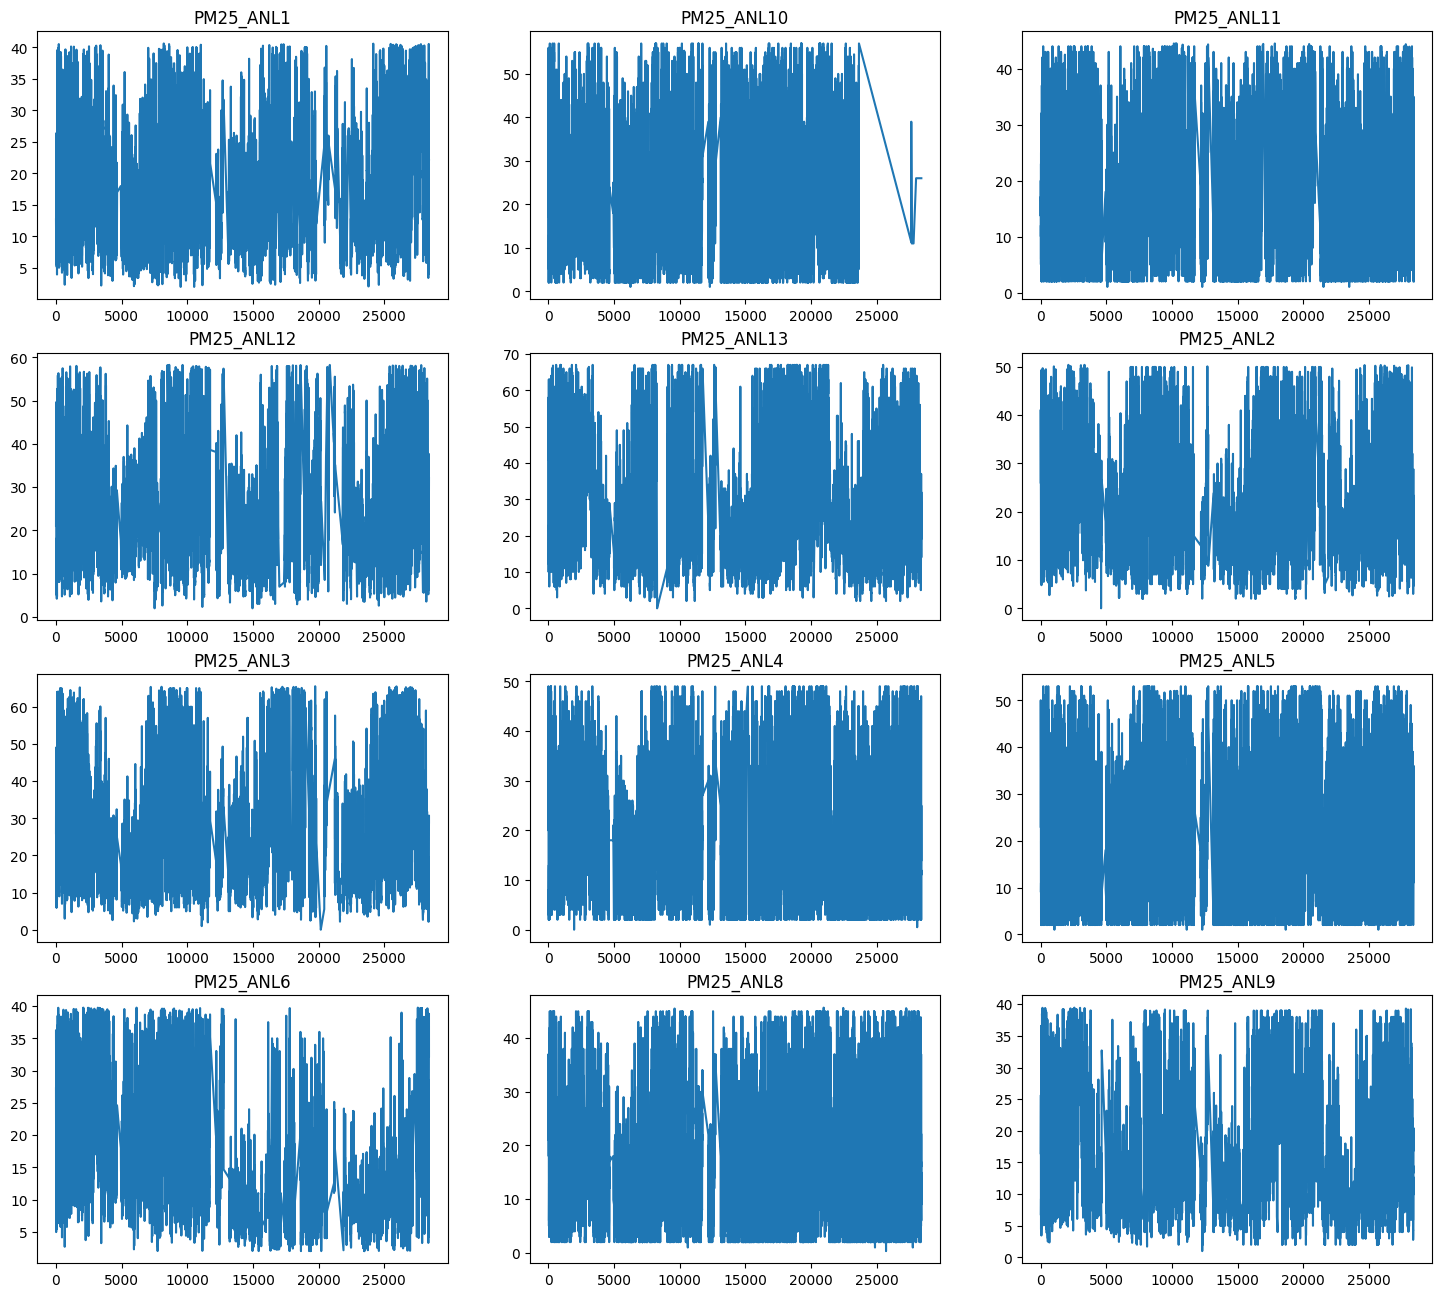

In [19]:
graph_metric(train_pm_df, "PM25")

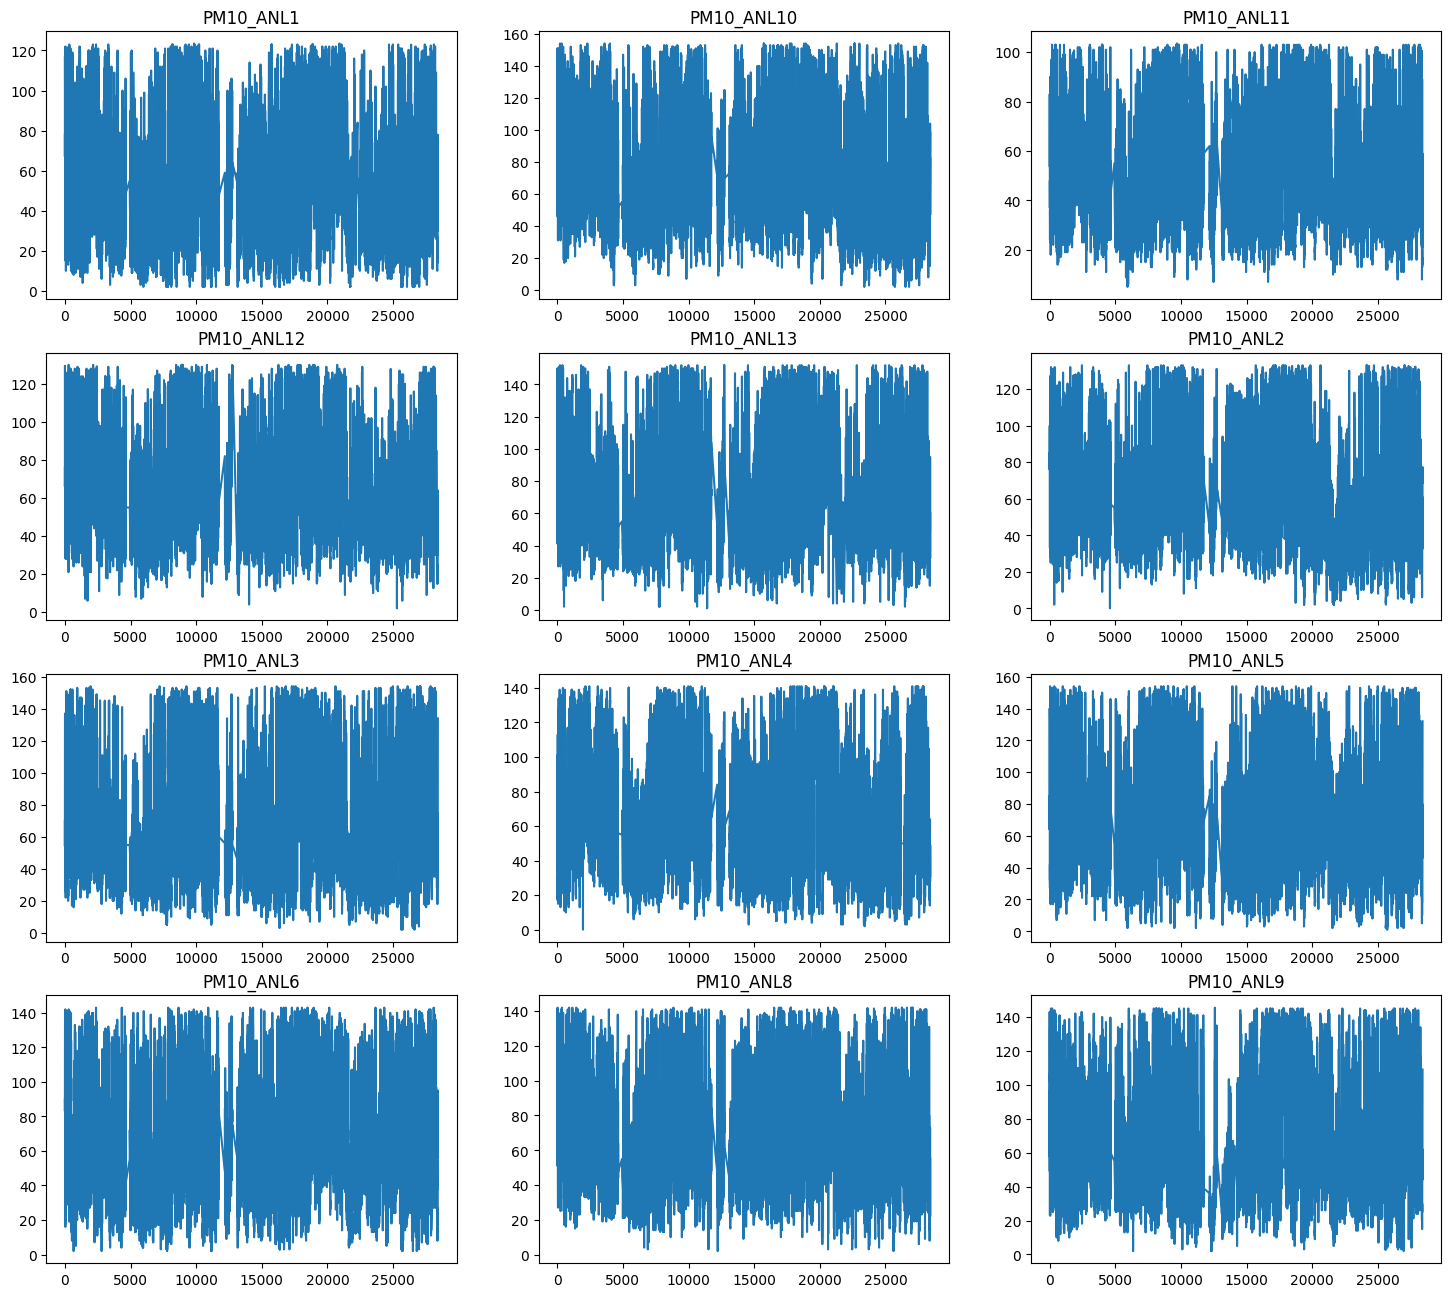

In [22]:
graph_metric(train_pm_df, "PM10")

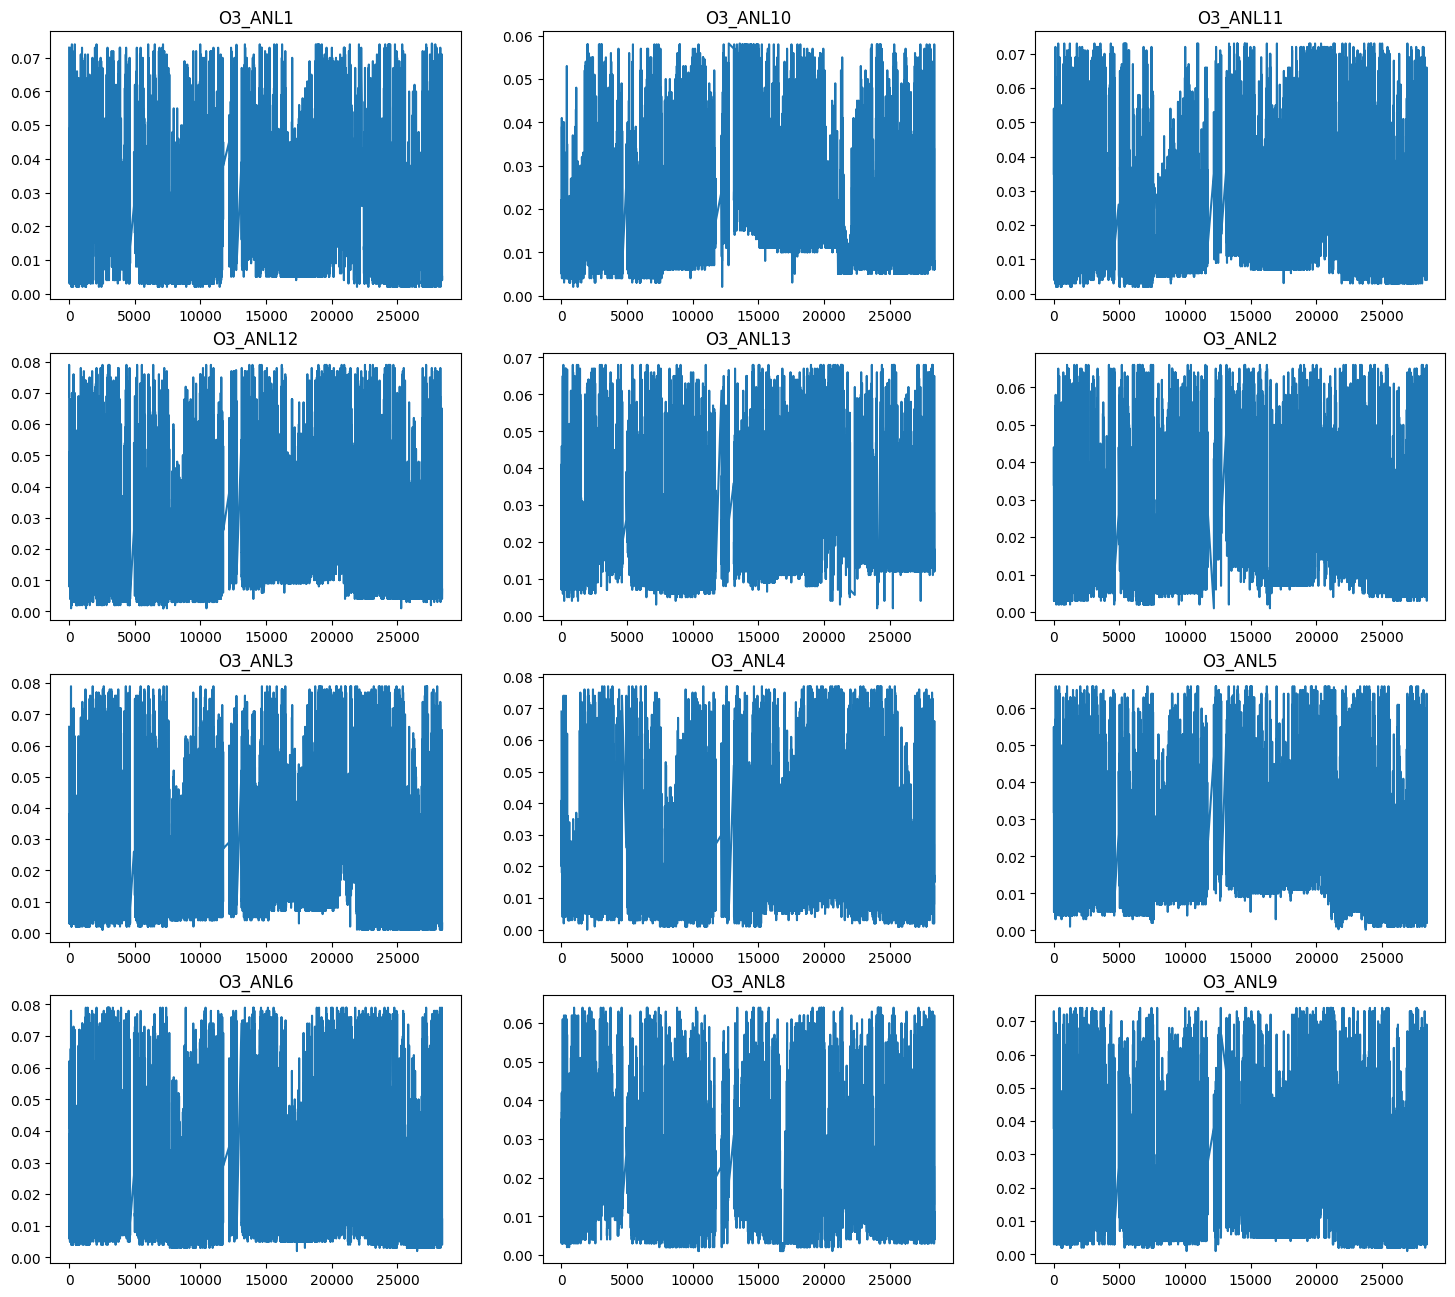

In [23]:
graph_metric(train_o3_df, "O3")

In [ ]:
# train models

from statsmodels.tsa.api import VAR

pm_model = VAR(train_pm_df)
pm_results = pm_model.fit(34)

def get_forecast(nsteps: int, dataframe, regressor, results_index):
    lag_order = regressor.k_ar
    forecast_input = dataframe[-lag_order:]
    forecast = regressor.forecast(y=forecast_input, steps=nsteps)
    forecast_df = pd.DataFrame(forecast, columns=dataframe.columns, index=results_index)

    return forecast_df



In [42]:
lag_order = pm_results.k_ar 
forecast_input = train_pm_df[-lag_order:]

pm_results.forecast(y=forecast_input, steps=10)

KeyError: -1

In [10]:
# existen sensores especificos con cantidades de valores faltantes para cada una de sus mediciones
# decidiremos eliminar ciertos sensores de nuestro forecast debido a una falta de datos. Si el porcentaje de valores faltantes
# del sensore es mayor a un 55%, el sensor no sera tomado en consideracion para el modelo predictivo.

# los siguientes sensores seran descartados


# Step 1: Make sure Dia is a datetime object
df['Dia'] = pd.to_datetime(df['Dia'])

# Step 2: Melt the data to long format
value_vars = ['PM10', 'PM25', 'O3', 'CO', 'NO1', 'NO2', 'NOx', 'SO2',
              'TEMPERATURA', 'LLUVIA', 'PRESIONATM', 'HUMEDAD', 'RS', 'VIENTOVEL']

df_long = df.melt(id_vars=['Dia', 'Sensor_id'],
                  value_vars=value_vars,
                  var_name='Measurement',
                  value_name='Value')

# Step 3: Pivot to wide format
df_wide = df_long.pivot_table(index='Dia',
                              columns=['Measurement', 'Sensor_id'],
                              values='Value')

# Step 4: Flatten the column MultiIndex
df_wide.columns = [f"{m}_{s}" for m, s in df_wide.columns]

# Step 5: Reindex to full hourly range
full_index = pd.date_range(start=df_wide.index.min(), end=df_wide.index.max(), freq='H')
df_wide = df_wide.reindex(full_index)

# Optional: rename index if you want
df_wide.index.name = 'Datetime'


In [11]:
df_wide.tail()

,CO_ANL1,CO_ANL10,CO_ANL11,CO_ANL12,CO_ANL13,CO_ANL15,CO_ANL16,CO_ANL2,CO_ANL3,CO_ANL4,...,VIENTOVEL_ANL15,VIENTOVEL_ANL16,VIENTOVEL_ANL2,VIENTOVEL_ANL3,VIENTOVEL_ANL4,VIENTOVEL_ANL5,VIENTOVEL_ANL6,VIENTOVEL_ANL7,VIENTOVEL_ANL8,VIENTOVEL_ANL9
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-04 09:00:00,NaN,NaN,0.23,1.47,0.59,0.484,1.26,0.82,0.11,NaN,...,1.3,2.8,5.1,0.0,3.8,2.5,4.3,2.7,6.3,5.9
2025-04-04 10:00:00,NaN,NaN,0.24,1.50,0.58,0.489,1.24,0.86,0.13,NaN,...,1.1,2.6,5.2,0.0,4.9,2.0,4.5,1.4,5.2,3.5
2025-04-04 11:00:00,NaN,NaN,0.28,1.58,0.62,0.495,1.31,0.81,0.14,NaN,...,1.2,7.4,6.6,0.0,6.5,5.6,6.2,0.9,3.9,6.0
2025-04-04 12:00:00,NaN,NaN,0.29,1.47,0.74,0.510,1.33,0.85,0.18,NaN,...,1.1,3.2,3.0,0.0,3.0,2.8,10.3,4.7,4.4,4.3
2025-04-04 13:00:00,NaN,NaN,0.50,1.64,0.80,0.516,1.90,1.00,0.95,NaN,...,1.1,2.6,2.5,0.0,5.3,2.5,11.2,1.4,3.9,2.8


In [12]:
# Antes de continuar, hay que deshacernos de sensores que tienen tan pocos datos que una interpolacion
# resultaria en un resultado con un alto margen de error

discard_sensors = [
    "ANL15",
    "ANL16",
    "ANL7",
    "ANL11",
    "ANL9",
    "ANL6",
    "ANL10",
    "ANL12",
    "ANL13", 
    "ANL1",
    "ANL3",
    "ANL4"
]

columns_to_remove = [
]

for col in df_wide.columns:
    if col.split("_")[1] in discard_sensors:
        columns_to_remove.append(col)

df_wide.drop(columns=columns_to_remove, inplace=True)

In [13]:
# antes de interpolar marcar las celdas con valores negativos como NaN para
# que sus valores verdaderos sean deducidos a traves de interpolacion

for col in df_wide.columns:
    df_wide[df_wide[col] < 0.0] = pd.NA

df_wide = df_wide.interpolate(method="time",limit_direction="both")

In [14]:
# see if there are still any cells with nan value

In [15]:
%matplotlib inline

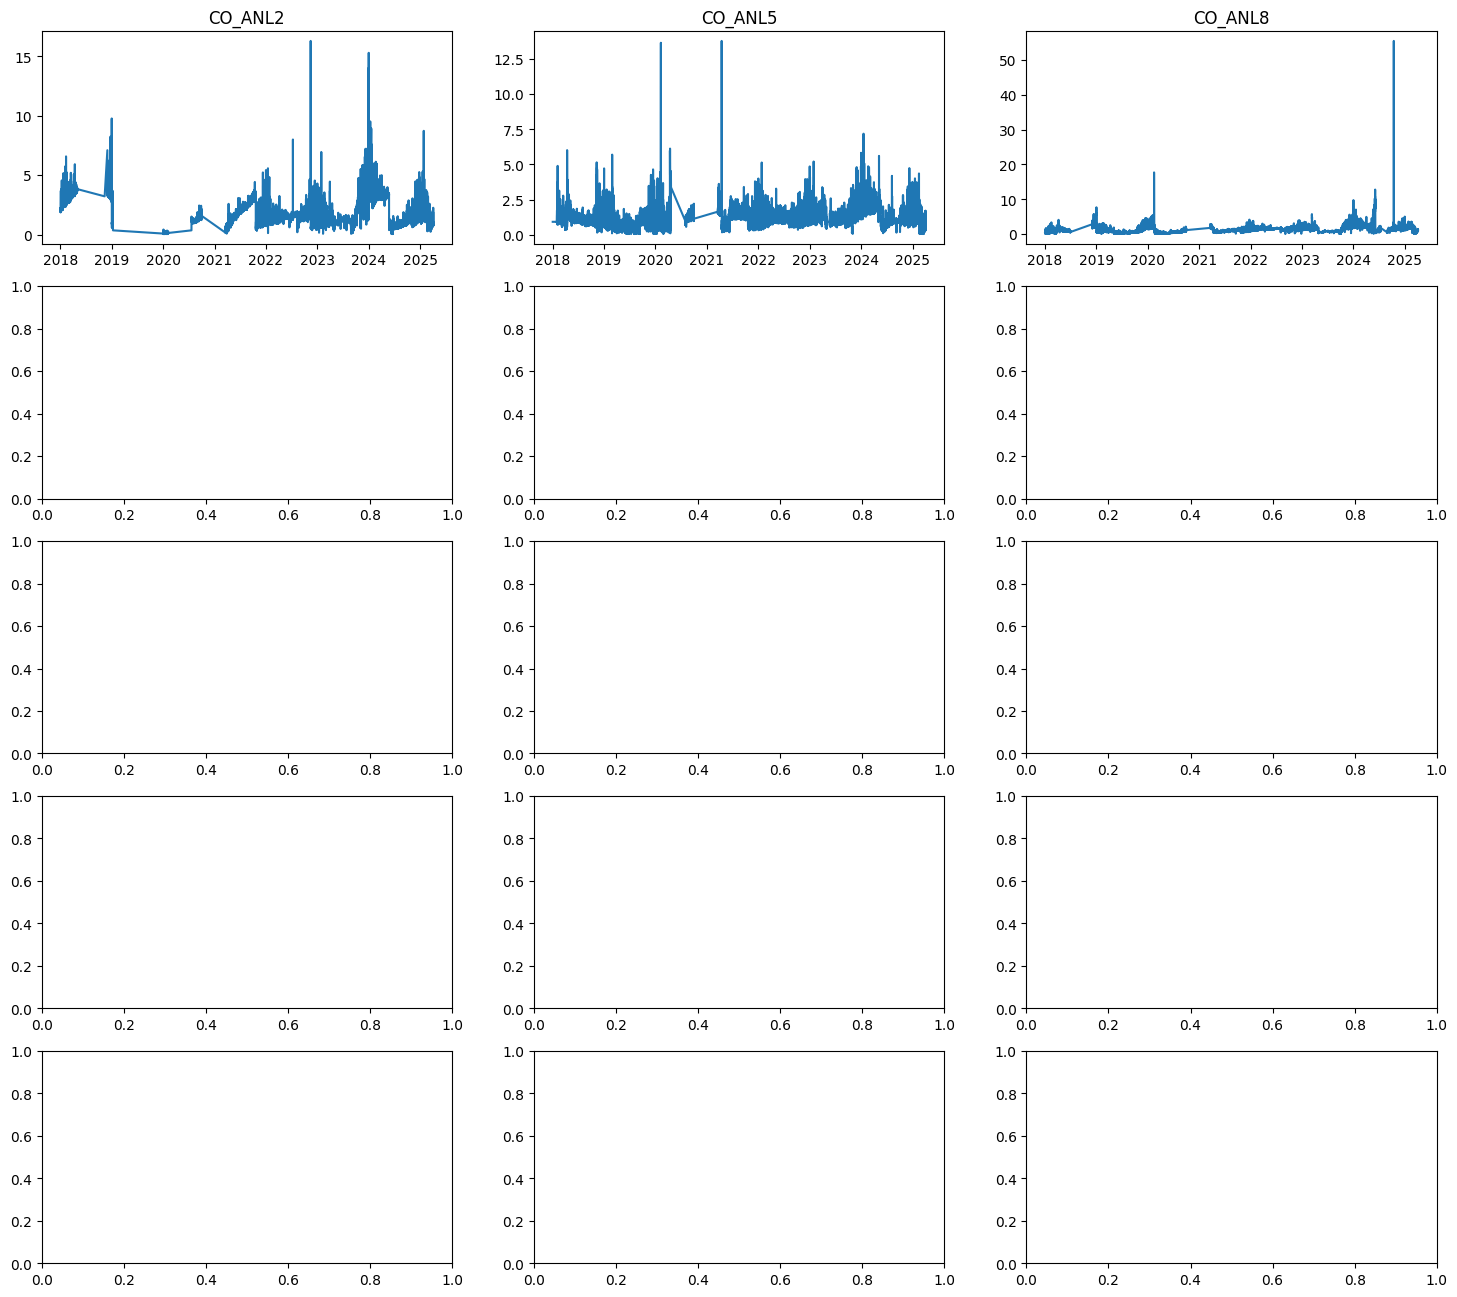

In [ ]:
# Visualizacion de datos

import matplotlib.pyplot as plt

def graph_metric(data_frame: pd.DataFrame, metric_name: str):
    # number of sensors after drop
    fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in data_frame.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(data_frame.index, data_frame[col])
            axs[i].set_title(col)
            i += 1


graph_metric(df_wide, "CO")

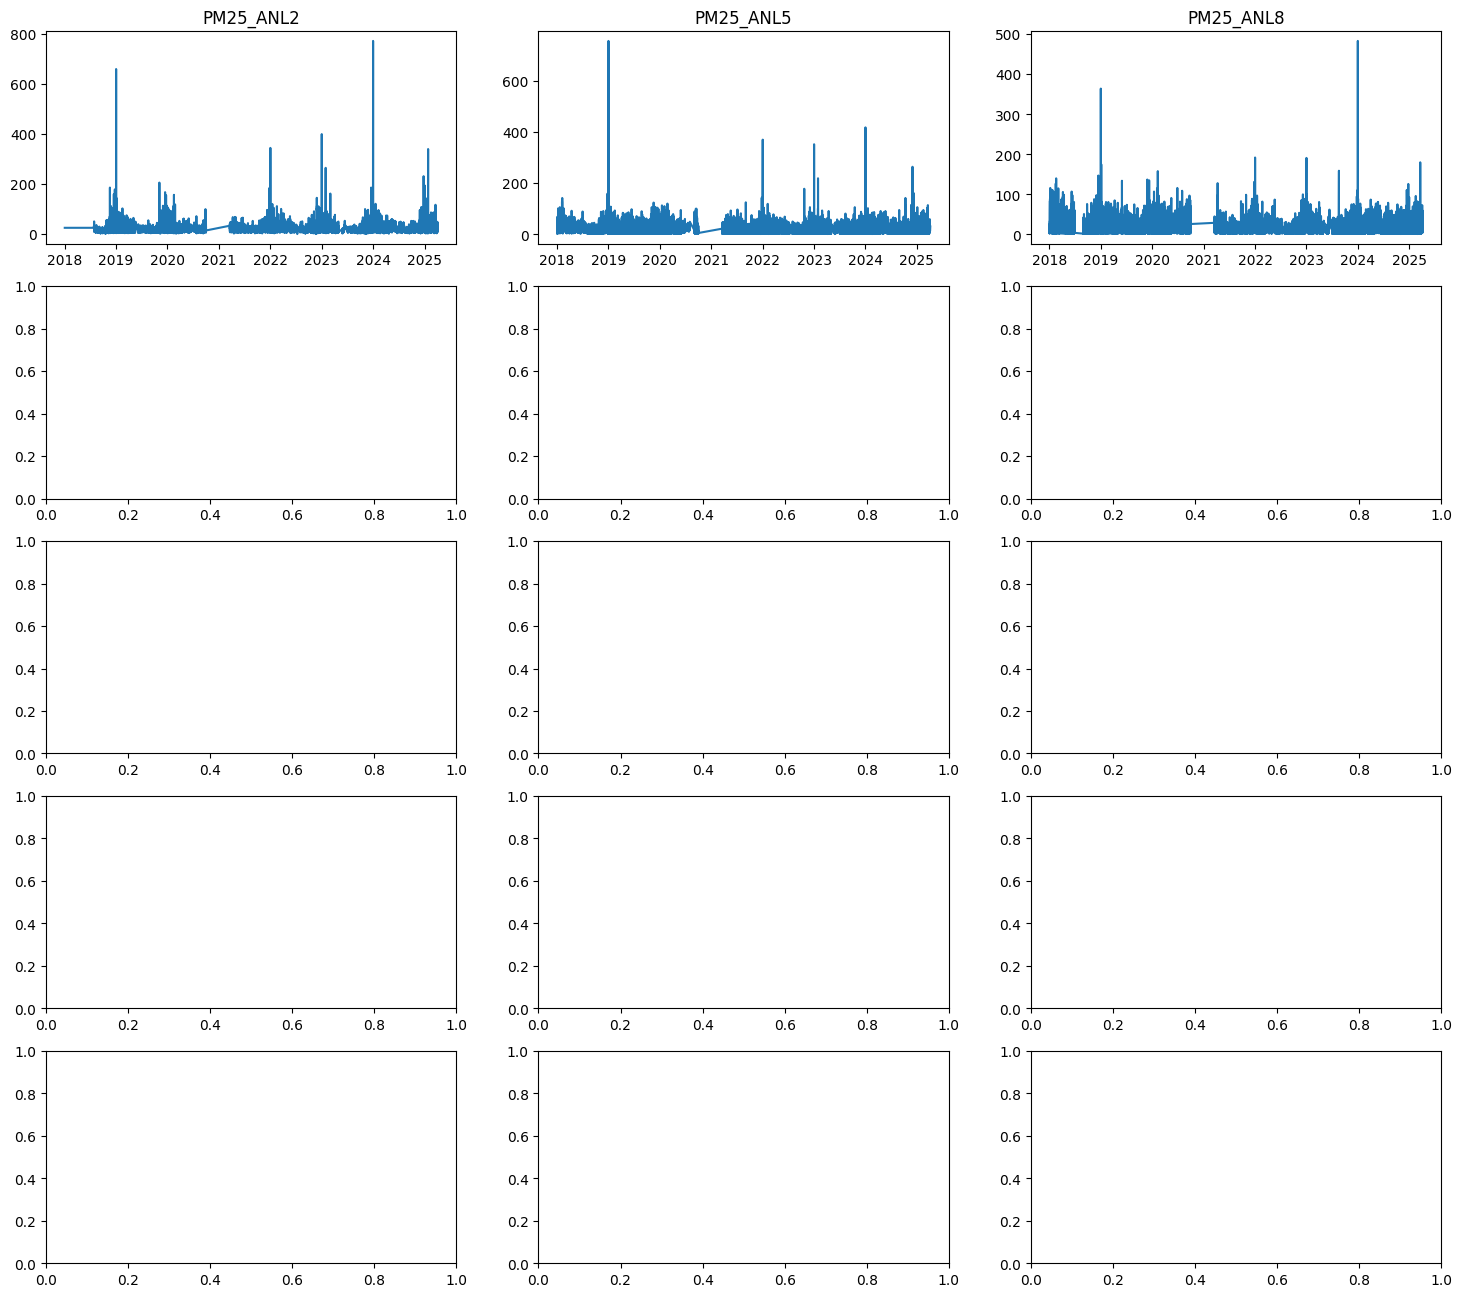

In [17]:
graph_metric(df_wide, "PM25")

In [18]:
df_wide.head()

,CO_ANL2,CO_ANL5,CO_ANL8,HUMEDAD_ANL2,HUMEDAD_ANL5,HUMEDAD_ANL8,LLUVIA_ANL2,LLUVIA_ANL5,LLUVIA_ANL8,NO1_ANL2,...,RS_ANL8,SO2_ANL2,SO2_ANL5,SO2_ANL8,TEMPERATURA_ANL2,TEMPERATURA_ANL5,TEMPERATURA_ANL8,VIENTOVEL_ANL2,VIENTOVEL_ANL5,VIENTOVEL_ANL8
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 08:00:00,2.20,0.92,0.32,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011700,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 09:00:00,2.17,0.92,0.31,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011500,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 10:00:00,2.14,0.92,0.29,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011300,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 11:00:00,2.10,0.92,0.26,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011300,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5
2018-01-01 12:00:00,2.05,0.92,0.24,80.0,74.0,79.0,0.0,0.0,0.0,0.0113,...,0.538,0.011233,0.0056,0.004,13.28,13.88,12.36,8.5,8.5,8.5


In [ ]:
# Entrenaremos un modelos de forecasting para series de tiempo llamado Vector Auto Regression

from datetime import datetime, date
from statsmodels.tsa.api import VAR, VARMAX

TRAIN_PERCENTAGE = 0.997
df_wide = df_wide[df_wide.index.year >= 2022]

train_df = df_wide[:int(len(df_wide)*TRAIN_PERCENTAGE)]
test_df = df_wide[int(len(df_wide)*TRAIN_PERCENTAGE):]

model = VAR(train_df)
results = model.fit(34) # take into conisderation 30 past values

In [ ]:
lag_order = results.k_ar
forecast_input = train_df.values[-lag_order:]

forecast = results.forecast(y=forecast_input, steps=len(test_df))  # next measurements
forecast_df = pd.DataFrame(forecast, columns=df_wide.columns, index=test_df.index)

def get_forecast(nsteps: int, dataframe, regressor):
    lag_order = regressor.k

In [20]:
len(test_df)

86

86


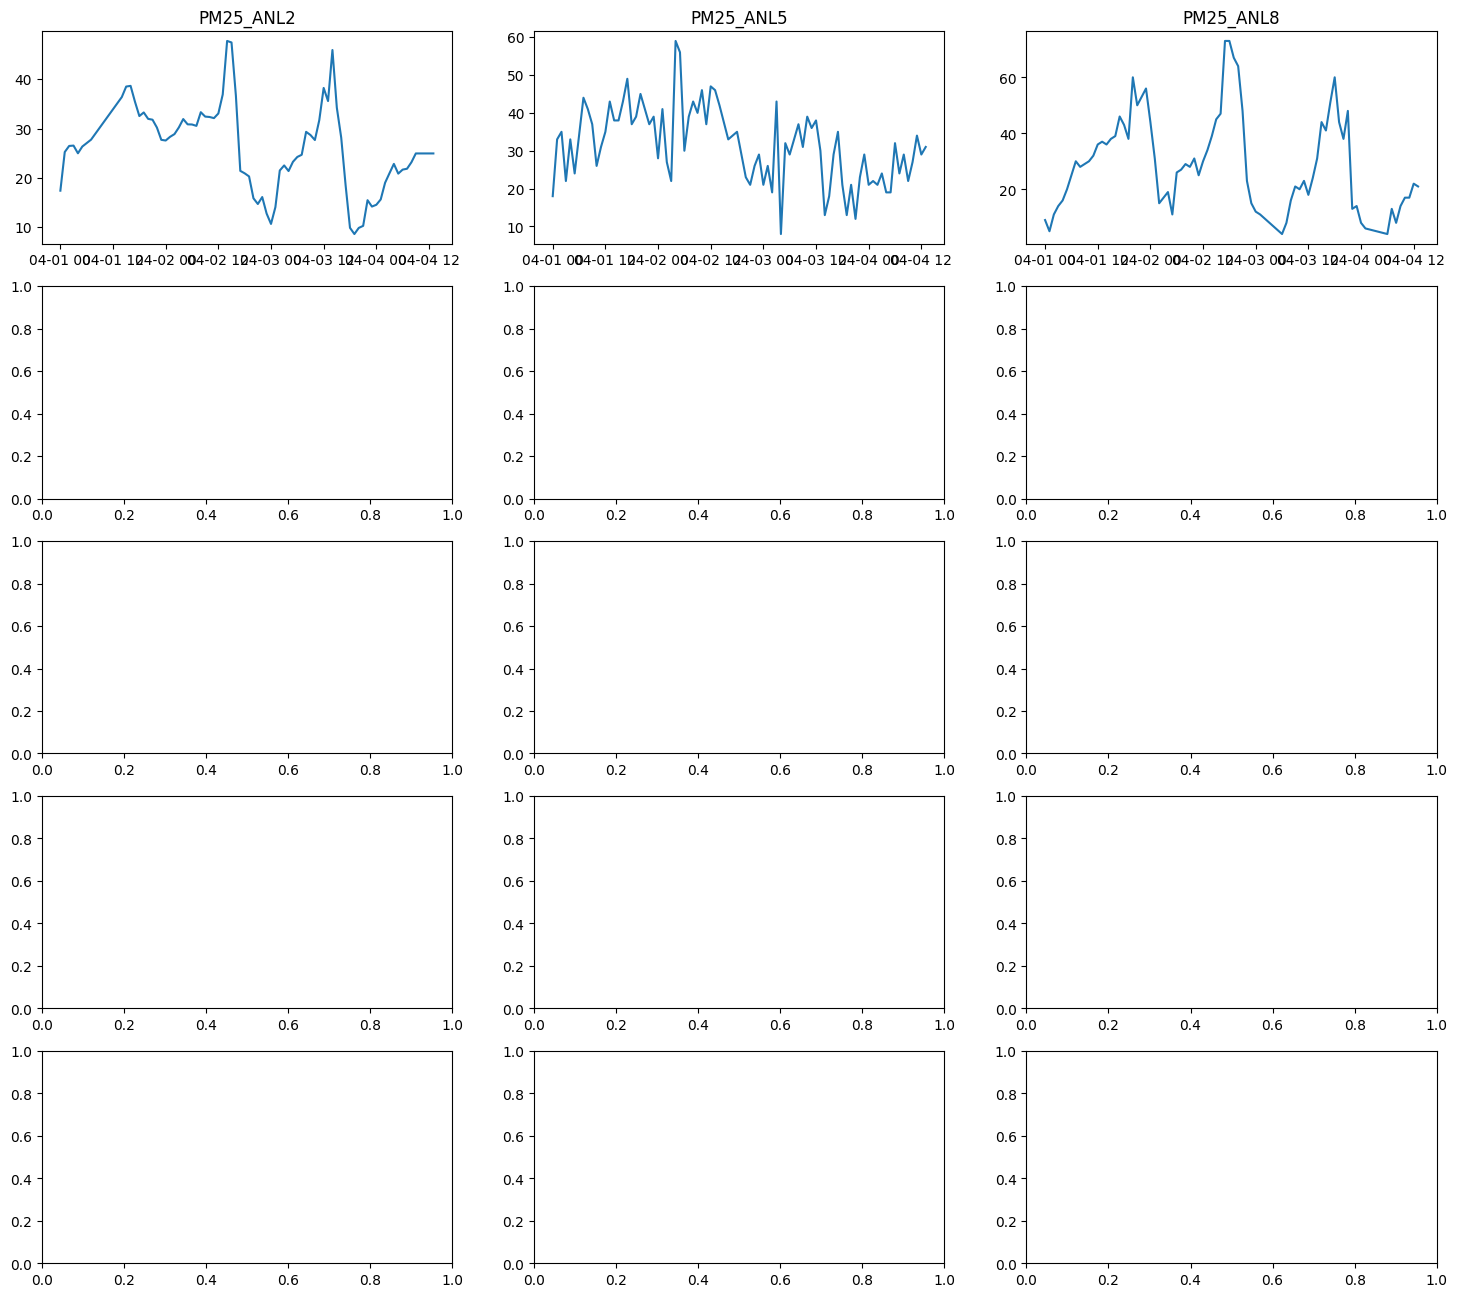

In [21]:
# revisamos los datos en test-df

print(len(test_df))   

graph_metric(test_df, "PM25")

In [22]:
lag_order = results.k_ar
forecast_input = train_df.values[-lag_order:]

forecast = results.forecast(y=forecast_input, steps=len(test_df))  # next measurements
forecast_df = pd.DataFrame(forecast, columns=df_wide.columns, index=test_df.index)


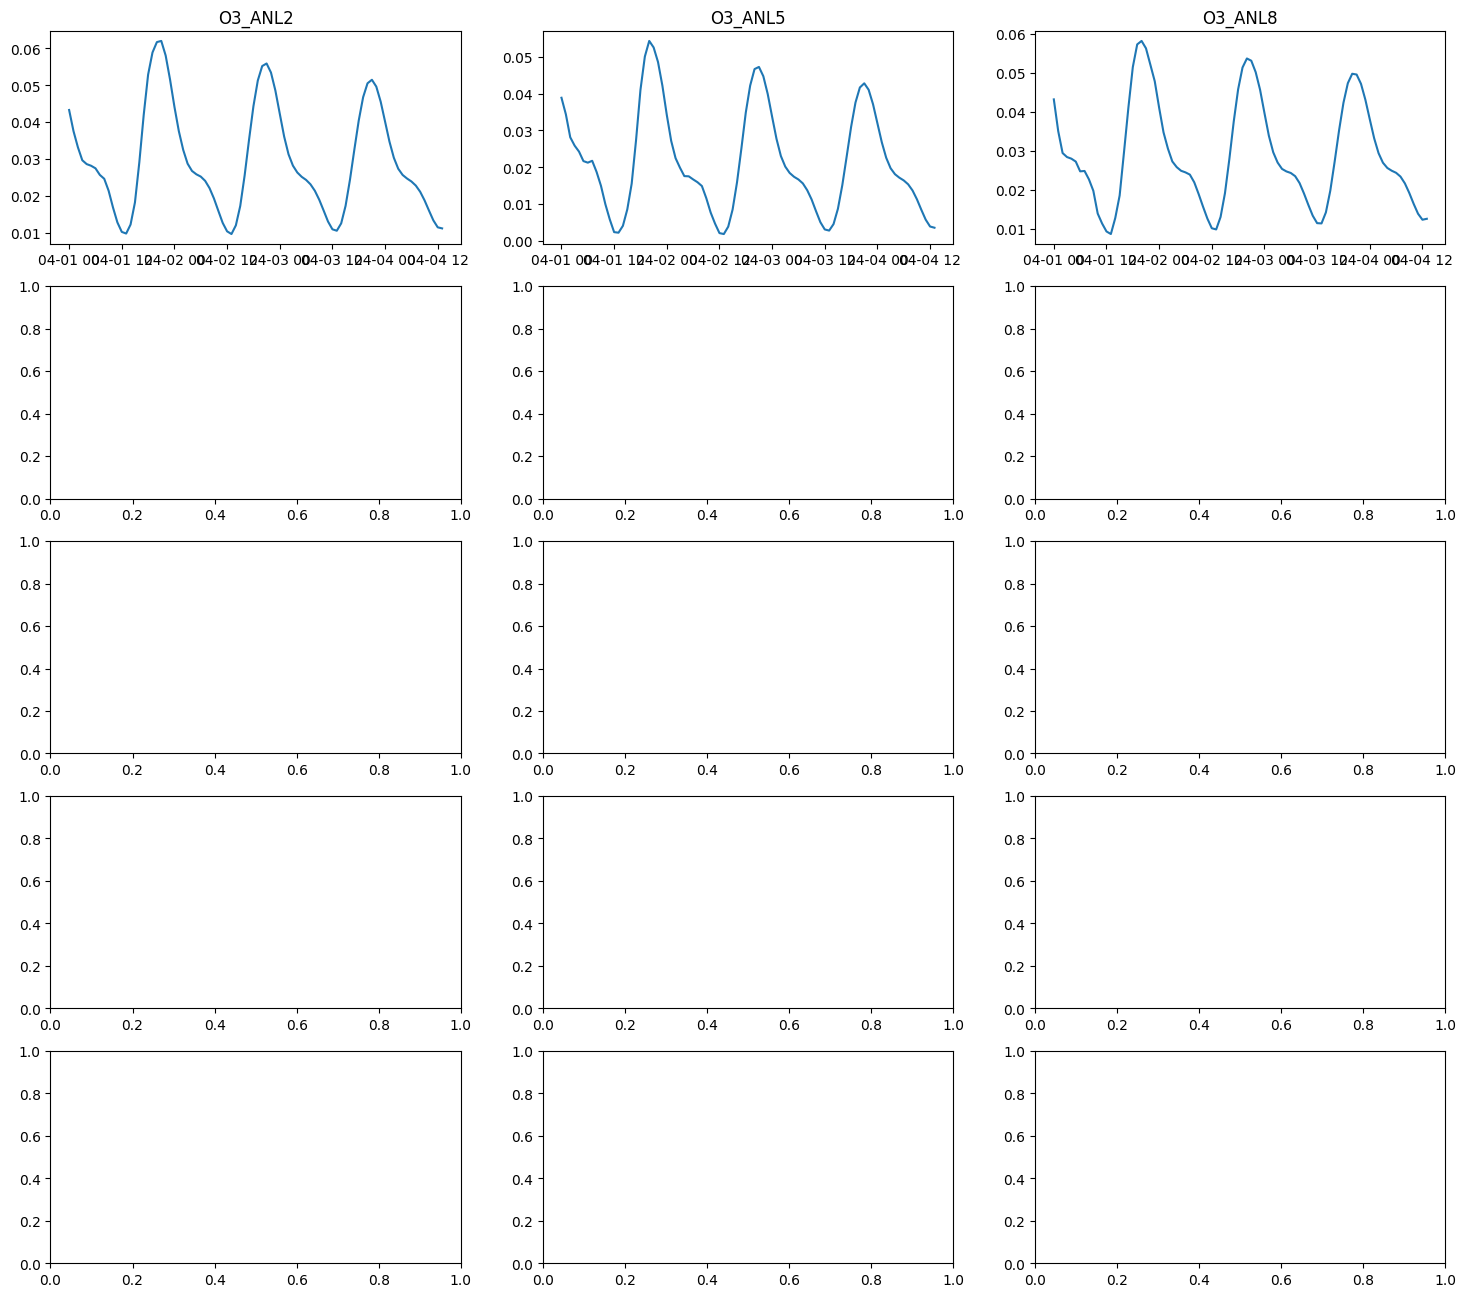

In [23]:
graph_metric(forecast_df, "O3")

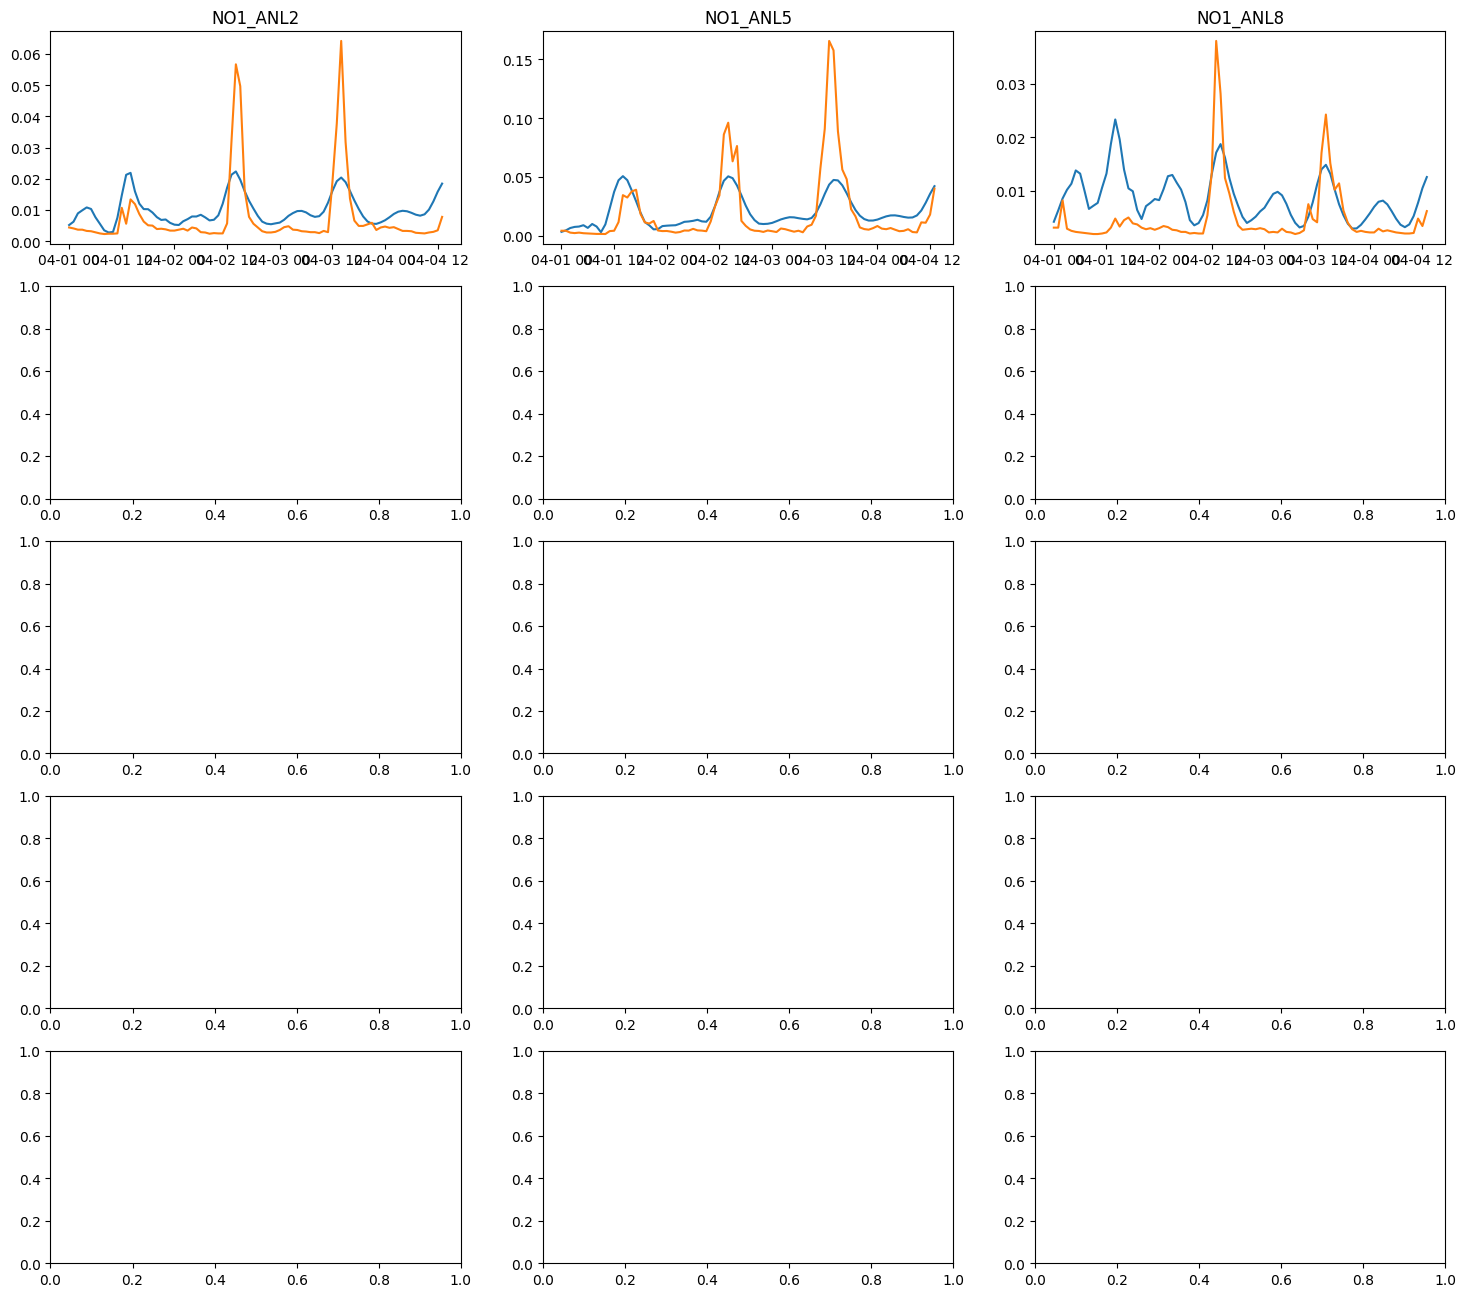

In [ ]:
from typing import List

def graph_metrics(forecast_df: pd.DataFrame, true_df: pd.DataFrame, metric_name: str):
    # number of sensors after drop

    fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    axs = axs.flatten()
    
    i: int = 0
    
    for col in forecast_df.columns:
        if col.split("_")[0] == metric_name:
            axs[i].plot(forecast_df.index, forecast_df[col], label="forecast")
            axs[i].plot(true_df.index, true_df[col], label="truth")
            axs[i].set_title(col)
            i += 1

graph_metrics(forecast_df, test_df, "NO1")


In [26]:
df_wide.to_csv("../data/processed/Cleaned_Data.csv", index=True)